In [2]:
!pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)


In [6]:
import kagglehub
import shutil
import os

path = kagglehub.dataset_download("noaa/seismic-waves")

dest_folder = r"C:\Users\Usuario\Desktop\Microcredencial\MicroDatosIA\first-practice"

os.makedirs(dest_folder, exist_ok=True)

for item in os.listdir(path):
    s = os.path.join(path, item)
    d = os.path.join(dest_folder, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Dataset copiado en: {dest_folder}")


Dataset copiado en: C:\Users\Usuario\Desktop\Microcredencial\MicroDatosIA\first-practice



=== Promedios por cluster ===
         MAXIMUM_HEIGHT  HORIZONTAL_INUNDATION  FATALITY_ESTIMATE  \
cluster                                                             
0              1.925606              20.959003           0.014858   
1             15.962909             129.420314           0.013592   
2              5.218998              46.454684           2.485839   
3              4.691059            2520.119873           0.076271   

         DAMAGE_ESTIMATE  
cluster                   
0               0.072962  
1               0.031715  
2               1.612200  
3               0.135593  


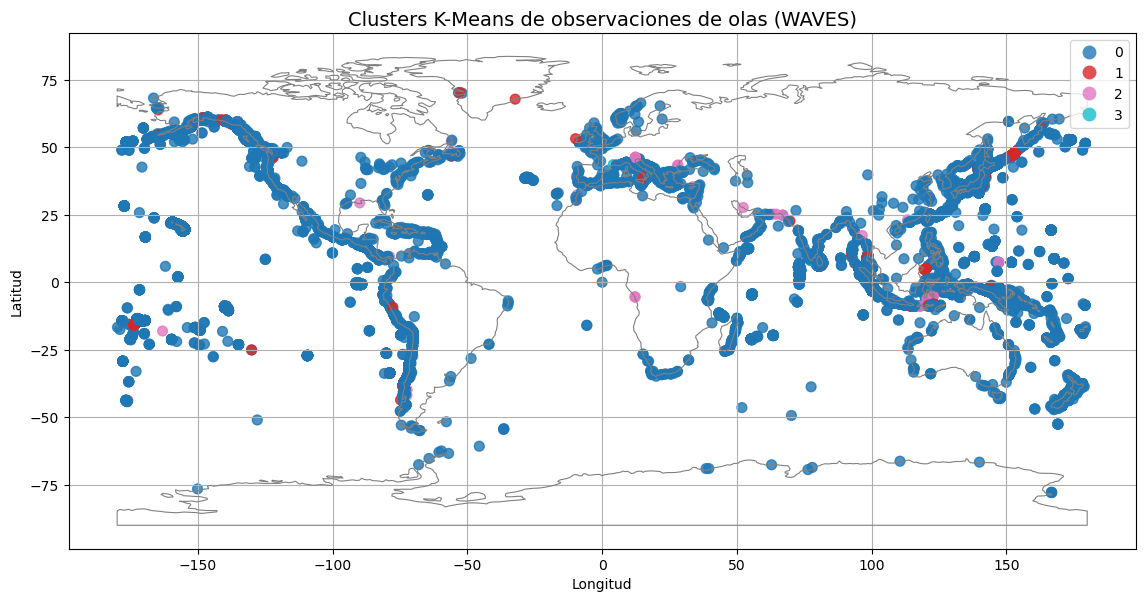

In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geodatasets

waves = pd.read_csv("waves.csv")

cols = [
    "COUNTRY",
    "LOCATION",
    "LATITUDE",
    "LONGITUDE",
    "MAXIMUM_HEIGHT",
    "HORIZONTAL_INUNDATION",
    "FATALITY_ESTIMATE",
    "DAMAGE_ESTIMATE"
]

waves = waves[cols].dropna(subset=[
    "LATITUDE", "LONGITUDE",
])

numeric_features = [
    "MAXIMUM_HEIGHT",
    "HORIZONTAL_INUNDATION",
    "FATALITY_ESTIMATE",
    "DAMAGE_ESTIMATE"
]

waves[numeric_features] = waves[numeric_features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(waves[numeric_features])

k = 4 
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
waves["cluster"] = kmeans.fit_predict(X_scaled)
waves["cluster"] = waves["cluster"].astype(int)

summary = waves.groupby("cluster")[numeric_features].mean()
print("\n=== Promedios por cluster ===")
print(summary)

gdf = gpd.GeoDataFrame(
    waves,
    geometry=gpd.points_from_xy(waves["LONGITUDE"], waves["LATITUDE"]),
    crs="EPSG:4326"
)

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

fig, ax = plt.subplots(figsize=(12, 6))
world.boundary.plot(ax=ax, linewidth=0.8, color="gray")

gdf["cluster"] = gdf["cluster"].astype("category")

gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    markersize=50,
    alpha=0.8,
    legend=True
)

ax.set_title("Clusters K-Means de observaciones de olas (WAVES)", fontsize=14)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(True)

plt.tight_layout()
plt.show()


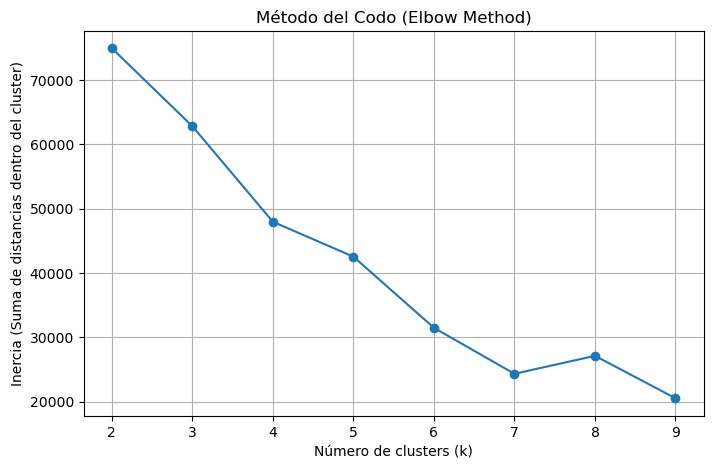

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 10)  # probar entre 2 y 9 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de distancias dentro del cluster)")
plt.grid(True)
plt.show()


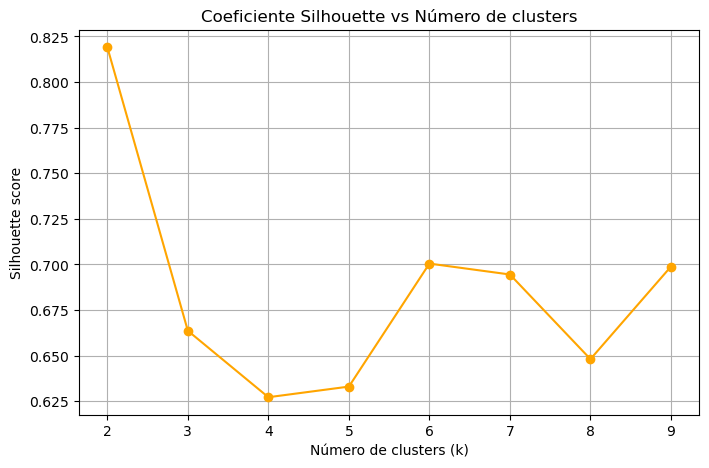

In [17]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.title("Coeficiente Silhouette vs Número de clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()



=== Modelo de regresión: Altura vs Año ===
Fórmula: MAXIMUM_HEIGHT = 335.1545 + -0.165542 * YEAR
R² (bondad de ajuste): 0.122


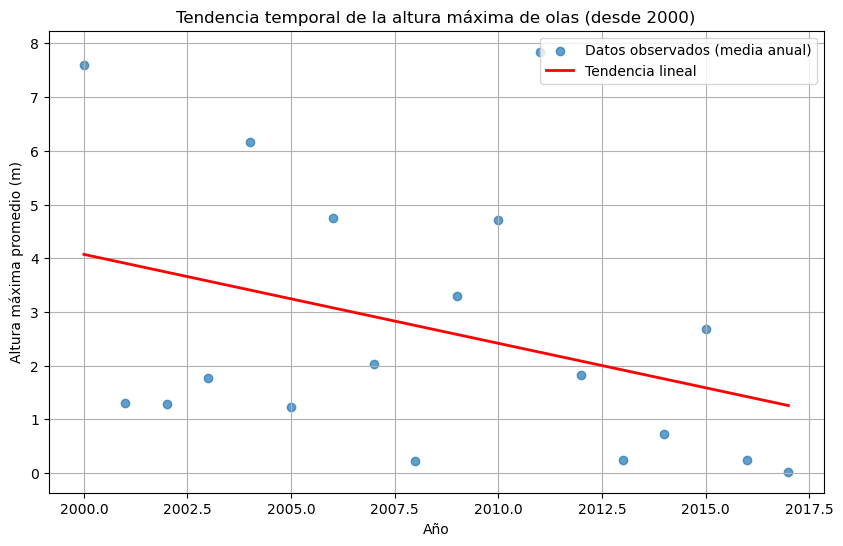

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# === 1. Cargar datos ===
waves = pd.read_csv("waves.csv")

# === 2. Seleccionar columnas relevantes ===
waves = waves[["YEAR", "MAXIMUM_HEIGHT"]].dropna(subset=["YEAR", "MAXIMUM_HEIGHT"])

# === 3. Filtrar desde el año 2000 en adelante ===
waves = waves[waves["YEAR"] >= 2000]

# === 4. Promediar por año (por si hay varios eventos por año) ===
data = waves.groupby("YEAR")["MAXIMUM_HEIGHT"].mean().reset_index()

# === 5. Preparar variables para la regresión ===
X = data["YEAR"].values.reshape(-1, 1)   # variable independiente
y = data["MAXIMUM_HEIGHT"].values        # variable dependiente

# === 6. Ajustar modelo lineal ===
model = LinearRegression()
model.fit(X, y)

# === 7. Predicciones ===
y_pred = model.predict(X)

# === 8. Coeficiente y calidad del ajuste ===
slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

print(f"\n=== Modelo de regresión: Altura vs Año ===")
print(f"Fórmula: MAXIMUM_HEIGHT = {intercept:.4f} + {slope:.6f} * YEAR")
print(f"R² (bondad de ajuste): {r2:.3f}")

# === 9. Graficar resultados ===
plt.figure(figsize=(10,6))
plt.scatter(X, y, color="tab:blue", alpha=0.7, label="Datos observados (media anual)")
plt.plot(X, y_pred, color="red", linewidth=2, label="Tendencia lineal")

plt.title("Tendencia temporal de la altura máxima de olas (desde 2000)")
plt.xlabel("Año")
plt.ylabel("Altura máxima promedio (m)")
plt.legend()
plt.grid(True)
plt.show()



Promedio anual de PC1 y PC2:
   YEAR       PC1       PC2
0  2001  4.210980  1.733985
1  2004  0.341630 -1.523850
2  2006  0.736706 -0.510824
3  2007  0.558215 -0.008189
4  2009 -0.106973 -0.766936

Varianza explicada:
PC1: 32.82%
PC2: 21.88%


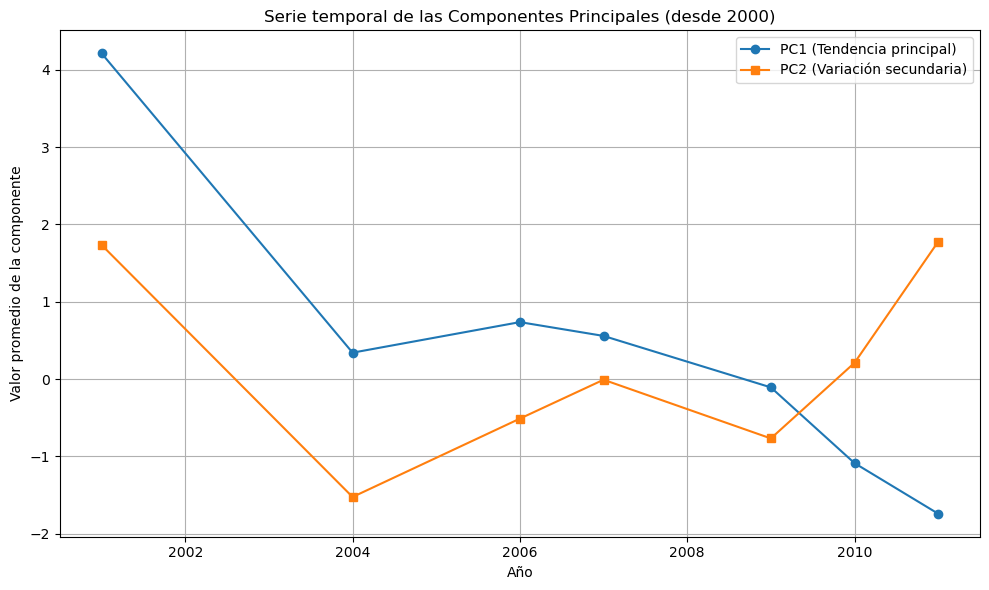

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

waves = pd.read_csv("waves.csv")

waves["MONTH_SIN"] = np.sin(2 * np.pi * waves["MONTH"] / 12)
waves["MONTH_COS"] = np.cos(2 * np.pi * waves["MONTH"] / 12)

cols = [
    "YEAR", "MONTH_SIN", "MONTH_COS",
    "MAXIMUM_HEIGHT", "HORIZONTAL_INUNDATION",
    "FATALITY_ESTIMATE", "DAMAGE_ESTIMATE"
]

waves = waves[waves["YEAR"] >= 2000]
waves = waves[cols].dropna()
waves = waves.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(waves)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

waves["PC1"] = X_pca[:, 0]
waves["PC2"] = X_pca[:, 1]
pca_yearly = waves.groupby("YEAR")[["PC1", "PC2"]].mean().reset_index()

print("\nPromedio anual de PC1 y PC2:")
print(pca_yearly.head())

print("\nVarianza explicada:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%}")

plt.figure(figsize=(10,6))
plt.plot(pca_yearly["YEAR"], pca_yearly["PC1"], marker="o", label="PC1 (Tendencia principal)")
plt.plot(pca_yearly["YEAR"], pca_yearly["PC2"], marker="s", label="PC2 (Variación secundaria)")

plt.title("Serie temporal de las Componentes Principales (desde 2000)")
plt.xlabel("Año")
plt.ylabel("Valor promedio de la componente")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
